# Let's Code - Projeto 2: ML em dados estruturados
## Bank personal loan modelling
Dataset utilizado: https://www.kaggle.com/krantiswalke/bank-personal-loan-

    O problema de negócio envolve a criação de um modelo capaz de prever se um novo cliente irá adquirir empréstimos pessoais. Para isso, o dataset trás diversas informações (descritas abaixo). Uma das dificuldades em trabalhar com esse dataset é a baixa incidência de clientes que adiquiriram empréstimos pessoais na última oferta feita, apenas 9,6%.

    O melhor modelo irá ajudar na otimização dos custos de marketing do banco, bem como no direcionamento de tais propagandas.



    Descrição das features:

Coluna|Descrição|
:-------------|:-----------------|
ID|Customer's ID
Age|Customer's age in completed years
Experience|Years of professional experience
Income|Annual income of the customer ($000)
ZIP Code|Home Address ZIP code
Family|Family size of the customer
CCAvg|Average spending on credit cards per month ($000)
Education|Education level (1 - Undergrad; 2 - Graduate; 3 - Advanced/Professional)
Mortgage|Value of house mortgage, if any ($000)
Personal Loan|Did this customer accept the personal loan offered in the last campaign?
Securities Account|Does the customer have a securities account with the bank?
CD Account|Does the customer have a certificate of deposit (CD) account with the bank?
Online|Does the customer use internet banking facilities?
Credit card|Does the customer use a credit card issued by?

In [158]:
# importação das bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

import warnings

warnings.simplefilter("ignore")

#### Importação e informação inicial dos dados

In [159]:
loan = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
loan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [160]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [161]:
# A coluna ID será descartada por não ter relevância para a análise e construção do modelo
loan.drop(columns=['ID', 'ZIP Code'], inplace=True)

    A feature 'ZIP Code' é um tanto problemática porque, apesar da sua importância para a construção do modelo, ela contém muitos valores únicos (de tipo inteiro) que não obedecem, necessariamente, uma hierarquia (exemplo: 91107 não é maior que 90089), já que representam regiões.

    Dessa forma, decidi remover essa feature.

#### Análise Exploratória

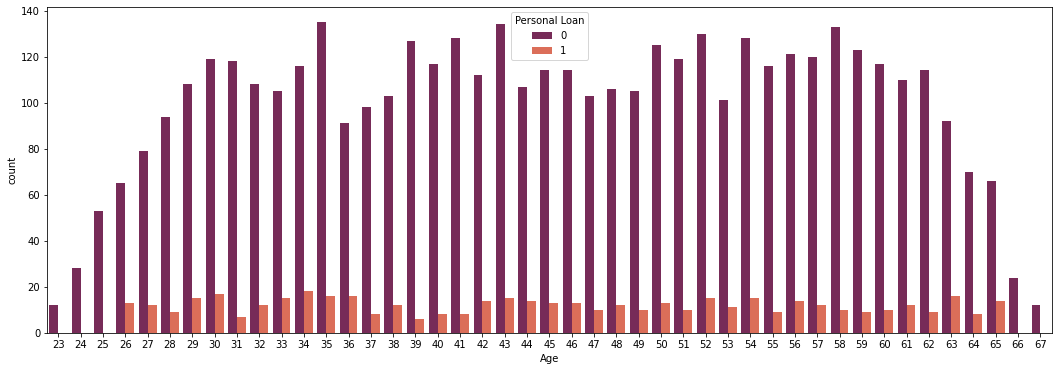

In [162]:
plt.figure(figsize=(18, 6))
sns.countplot(data=loan, x='Age', hue='Personal Loan', palette='rocket');

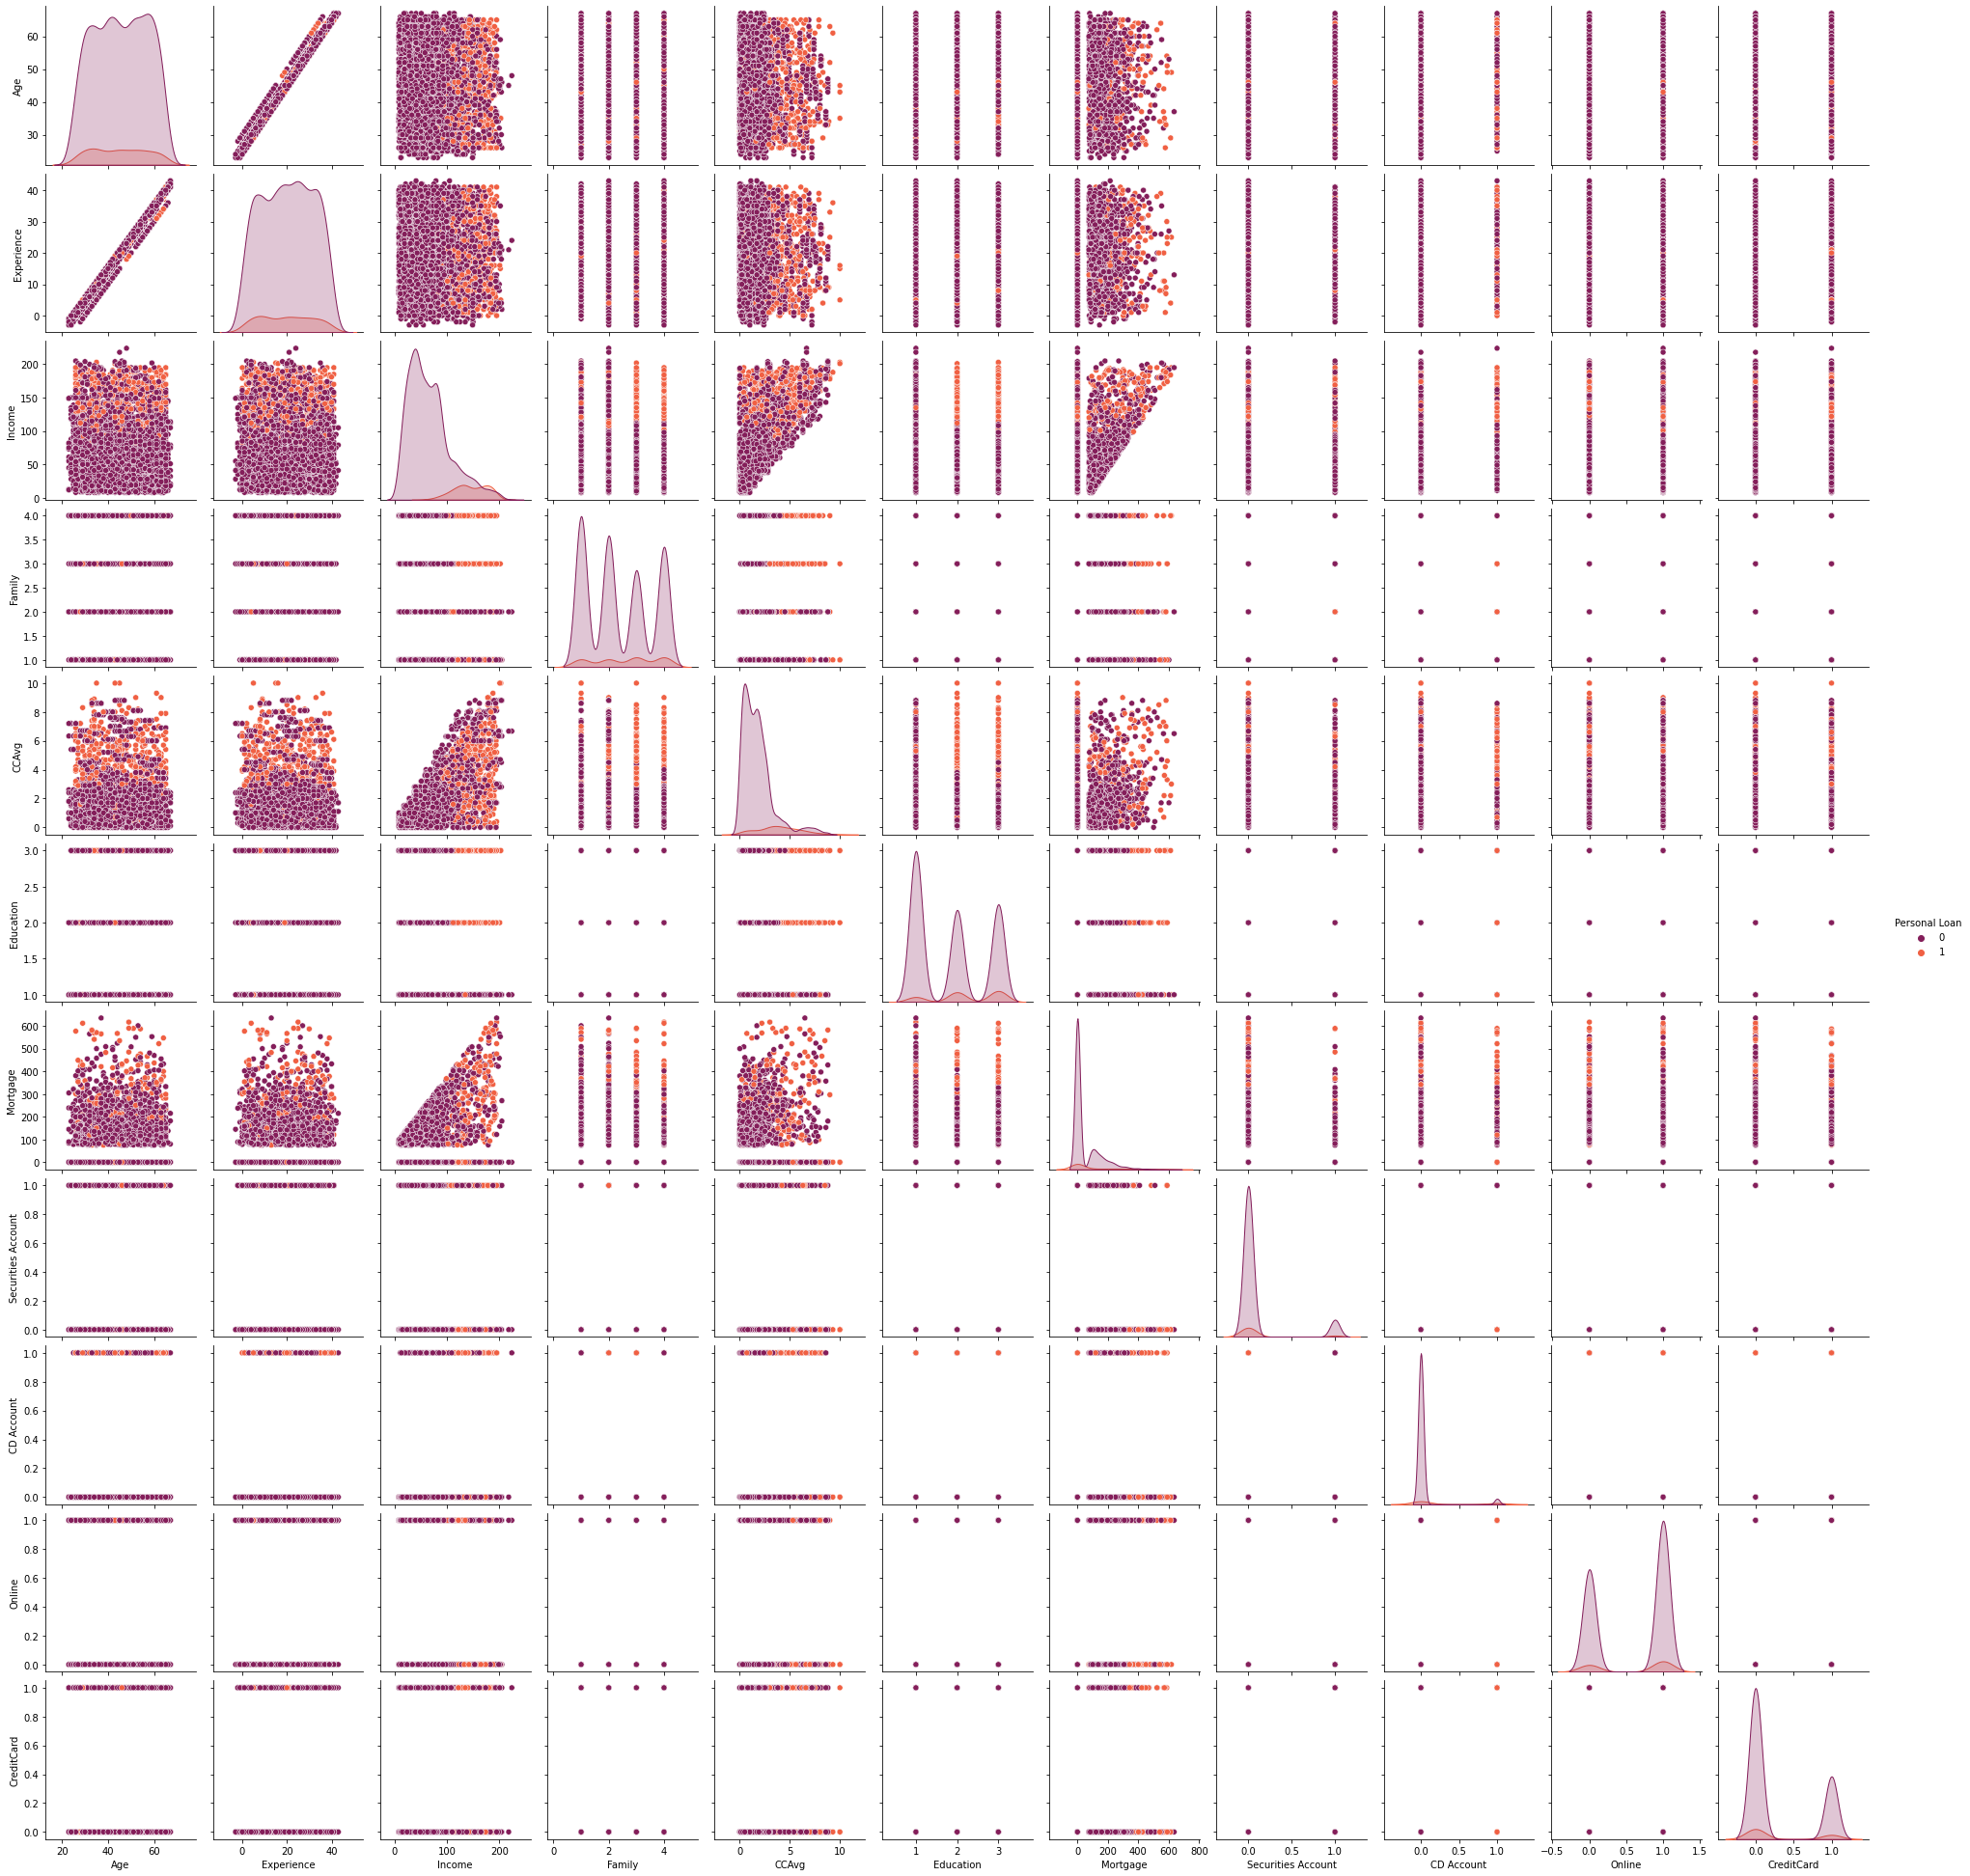

In [163]:
sns.pairplot(loan, hue='Personal Loan', palette='rocket')

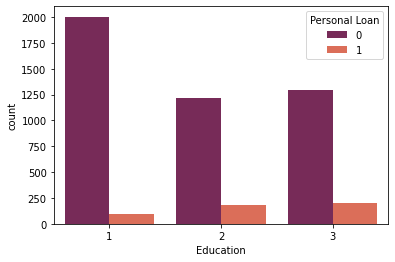

In [7]:
sns.countplot(data=loan, x='Education', palette='rocket', hue='Personal Loan');

In [8]:
loan['Personal Loan'].value_counts(normalize=True)

0    0.904
1    0.096
Name: Personal Loan, dtype: float64

    O countplot revela que a quantidade de pessoas, por idade, que adquiriram um empréstimo pessoal é uniformemente distribuída. Ou seja, nenhuma das faixas de idade se destacam largamente em relação às das outras nesse âmbito.

    Além disso, o nível de educação mais frequente entre os clientes é o nível 1 (undergrad). Porém, as pessoas que mais realizaram o empréstimo são as do nível 3 (advanced/professional).

#### Comparação dos modelos

    Modelos que serão testados:
- Regressão logística
- KNN
- Random forest
- Support Vector Machine (SVM)
- AdaBoost

##### Preprocessamento

In [155]:
X = loan.drop(columns=['Personal Loan'])
y = loan['Personal Loan']

    Escolhi a técnica hold-out para separação dos dados de treino, teste e validação.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

In [106]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.3,
                                                  stratify=y_train,
                                                  random_state=42)

    Por conta da baixa incidência da target no dataset, como já foi citado anteriormente, apliquei o Over Sampling para balancear os dados de treino.

In [107]:
ros = RandomOverSampler()

In [108]:
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

##### Regressão Logística

In [109]:
model_rl = LogisticRegression()
model_rl.fit(X_train_resampled, y_train_resampled)
y_pred_rl = model_rl.predict(X_val)

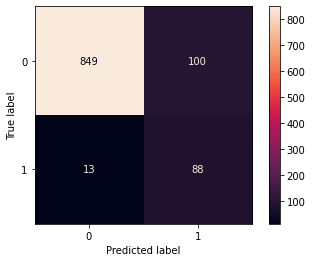

In [110]:
cm_rl = confusion_matrix(y_val, y_pred_rl)
ConfusionMatrixDisplay(cm_rl).plot(cmap='rocket');

In [164]:
print(classification_report(y_val, y_pred_rl, digits=4))

              precision    recall  f1-score   support

           0     0.9849    0.8946    0.9376       949
           1     0.4681    0.8713    0.6090       101

    accuracy                         0.8924      1050
   macro avg     0.7265    0.8830    0.7733      1050
weighted avg     0.9352    0.8924    0.9060      1050



##### KNN

In [165]:
random_search_knn = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                                       param_distributions={'n_neighbors': [i for i in range(1, 31)]},
                                       scoring='precision')

In [166]:
random_search_knn.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29, 30]},
                   scoring='precision')

In [167]:
random_search_knn.best_estimator_

KNeighborsClassifier(n_neighbors=2)

In [168]:
pipe_knn = Pipeline([('scaler', StandardScaler()),
                     ('model', KNeighborsClassifier(n_neighbors=2))])

In [169]:
pipe_knn.fit(X_train_resampled, y_train_resampled)

y_pred_knn = pipe_knn.predict(X_val)

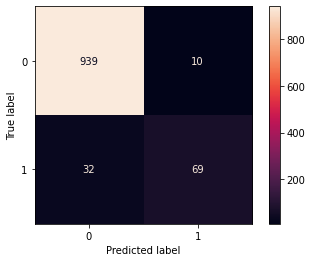

In [170]:
cm_knn = confusion_matrix(y_val, y_pred_knn)
ConfusionMatrixDisplay(cm_knn).plot(cmap='rocket');

In [171]:
print(classification_report(y_val, y_pred_knn, digits=4))

              precision    recall  f1-score   support

           0     0.9670    0.9895    0.9781       949
           1     0.8734    0.6832    0.7667       101

    accuracy                         0.9600      1050
   macro avg     0.9202    0.8363    0.8724      1050
weighted avg     0.9580    0.9600    0.9578      1050



##### Random Forest

In [119]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [120]:
# Parâmetros do Random Forest para teste

criterions = ['gini', 'entropy']

max_depth = [x for x in range(2, 8)] + [None]

min_samples_split = [x for x in range(2, 8)]

min_samples_leaf = [x for x in range(1, 5)]

params_grid = {'criterion': criterions,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [121]:
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(),
                              param_grid=params_grid,
                              scoring='precision',
                              cv=StratifiedKFold())

In [122]:
grid_search_rf.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, None],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6, 7]},
             scoring='precision')

In [123]:
grid_search_rf.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

In [147]:
model_rf = RandomForestClassifier(criterion='entropy',
                                  min_samples_leaf=1,
                                  min_samples_split=3)
model_rf.fit(X_train_resampled, y_train_resampled)

y_pred_rf = model_rf.predict(X_val)

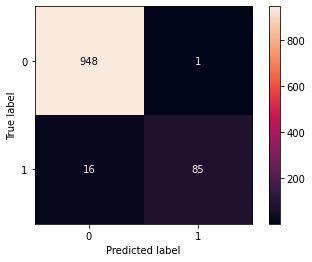

In [148]:
cm_rf = confusion_matrix(y_val, y_pred_rf)
ConfusionMatrixDisplay(cm_rf).plot(cmap='rocket');

In [149]:
print(classification_report(y_val, y_pred_rf, digits=4))

              precision    recall  f1-score   support

           0     0.9834    0.9989    0.9911       949
           1     0.9884    0.8416    0.9091       101

    accuracy                         0.9838      1050
   macro avg     0.9859    0.9203    0.9501      1050
weighted avg     0.9839    0.9838    0.9832      1050



##### SVM

In [127]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [128]:
kernel_param = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

C_param = [0.001, 0.01, 0.1, 1]

In [129]:
pipe_svm = Pipeline([('scaler', StandardScaler()),
                     ('model', SVC())])

In [130]:
pipe_svm.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('model', SVC())],
 'verbose': False,
 'scaler': StandardScaler(),
 'model': SVC(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__C': 1.0,
 'model__break_ties': False,
 'model__cache_size': 200,
 'model__class_weight': None,
 'model__coef0': 0.0,
 'model__decision_function_shape': 'ovr',
 'model__degree': 3,
 'model__gamma': 'scale',
 'model__kernel': 'rbf',
 'model__max_iter': -1,
 'model__probability': False,
 'model__random_state': None,
 'model__shrinking': True,
 'model__tol': 0.001,
 'model__verbose': False}

In [131]:
grid_search_svm = GridSearchCV(pipe_svm,
                               param_grid={'model__C': C_param,
                                           'model__kernel': kernel_param},
                                cv=StratifiedKFold(),
                                scoring='precision')

In [132]:
grid_search_svm.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC())]),
             param_grid={'model__C': [0.001, 0.01, 0.1, 1],
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                           'precomputed']},
             scoring='precision')

In [133]:
grid_search_svm.best_params_

{'model__C': 0.001, 'model__kernel': 'poly'}

In [134]:
pipe_svm = Pipeline([('scaler', StandardScaler()),
                     ('model', SVC(C=0.001, kernel='poly'))])

pipe_svm.fit(X_train_resampled, y_train_resampled)

y_pred_svm = pipe_svm.predict(X_val)

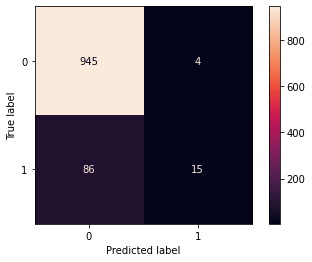

In [135]:
cm_svm = confusion_matrix(y_val, y_pred_svm)
ConfusionMatrixDisplay(cm_svm).plot(cmap='rocket');

In [136]:
print(classification_report(y_val, y_pred_svm, digits=4))

              precision    recall  f1-score   support

           0     0.9166    0.9958    0.9545       949
           1     0.7895    0.1485    0.2500       101

    accuracy                         0.9143      1050
   macro avg     0.8530    0.5721    0.6023      1050
weighted avg     0.9044    0.9143    0.8868      1050



##### AdaBoost

In [137]:
model_ab = AdaBoostClassifier()

model_ab.fit(X_train_resampled, y_train_resampled)

y_pred_ab = model_ab.predict(X_val)

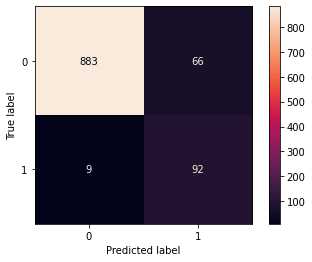

In [138]:
cm_ab = confusion_matrix(y_val, y_pred_ab)
ConfusionMatrixDisplay(cm_ab).plot(cmap='rocket');

In [139]:
print(classification_report(y_val, y_pred_ab, digits=4))

              precision    recall  f1-score   support

           0     0.9899    0.9305    0.9593       949
           1     0.5823    0.9109    0.7104       101

    accuracy                         0.9286      1050
   macro avg     0.7861    0.9207    0.8348      1050
weighted avg     0.9507    0.9286    0.9353      1050



#### Conclusão

    A métrica principal que escolhi, tanto para a otimização de parâmetro quanto para analisar a performance do modelo, foi a "accuracy". Tomei essa escolha com base no fundamento lógico dessa métrica: nesse dataset, tal métrica indica a quem deve ser direcionado tais esforços para propor o empréstimo pessoal, já que a previsão errada disso implicaria em um maior custo.

    Dessa forma, o modelo que performou melhor foi o Random Forest. O KNN e o AdaBoost também tiveram um bom desempenho.

In [150]:
# performance geral dos modelos
models_preds = {'Regressão Logística': y_pred_rl,
                'KNN': y_pred_knn,
                'Random Forest': y_pred_rf,
                'SVM': y_pred_svm,
                'AdaBoost': y_pred_ab} 

models = [model_name for model_name in models_preds.keys()]
precision = [precision_score(y_val, model_y_pred) for model_y_pred in models_preds.values()]
recall = [recall_score(y_val, model_y_pred) for model_y_pred in models_preds.values()]
f1score = [f1_score(y_val, model_y_pred) for model_y_pred in models_preds.values()]
accuracy = [accuracy_score(y_val, model_y_pred) for model_y_pred in models_preds.values()]

final_performance = pd.DataFrame({'Models': models,
                                  'Precision': precision,
                                  'Recall': recall,
                                  'F1-score': f1score,
                                  'Accuracy': accuracy})
final_performance

,Models,Precision,Recall,F1-score,Accuracy
0,Regressão Logística,0.468085,0.871287,0.608997,0.892381
1,KNN,0.873418,0.683168,0.766667,0.960000
2,Random Forest,0.988372,0.841584,0.909091,0.983810
3,SVM,0.789474,0.148515,0.250000,0.914286
4,AdaBoost,0.582278,0.910891,0.710425,0.928571


    Finalmente, aplicando o modelo escolhido na base de testes.

In [151]:
y_pred_rf_test = model_rf.predict(X_test)

In [152]:
print(classification_report(y_test, y_pred_rf_test, digits=4))

              precision    recall  f1-score   support

           0     0.9912    0.9971    0.9941      1356
           1     0.9706    0.9167    0.9429       144

    accuracy                         0.9893      1500
   macro avg     0.9809    0.9569    0.9685      1500
weighted avg     0.9892    0.9893    0.9892      1500



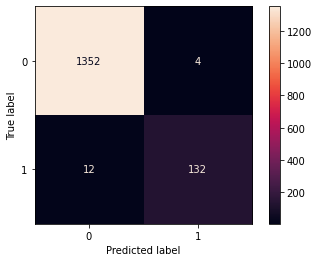

In [153]:
cm_rf_test = confusion_matrix(y_test, y_pred_rf_test)
ConfusionMatrixDisplay(cm_rf_test).plot(cmap='rocket');

    O modelo até performou um pouco melhor na base de testes.